# Loading/Testing CM2.6 data + naive air sea flux attempt


## Notes
- The regridding will crash for the global dataset. Trying a subset now
- We have a grid file for the ocean, but not the atmosphere? confirm that this is regular lon/lat grid




rho = density of moist air

C_H = exchange coefficient for sensible heat

C_P = heat capacity of moist air


In [1]:
import xarray as xr
import intake
import xesmf as xe
from dask.diagnostics import ProgressBar

In [2]:
# load the ocean data
from intake import open_catalog
kwargs = dict(consolidated=True, use_cftime=True)
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
ds_flux  = cat["GFDL_CM2_6_control_ocean_boundary_flux"].to_dask()
ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', **kwargs)
ds_grid  = cat["GFDL_CM2_6_grid"].to_dask()

In [3]:
# convert SST to K (🚨 a job for pint-xarray)
ds['surface_temp'] = ds.surface_temp + 273.15

In [4]:
# cut to same size
ds_atmos = ds_atmos.sel(time=slice('0181', '0201'))
ds_atmos

<xarray.Dataset>
Dimensions:       (time: 7305, grid_yt: 360, grid_xt: 576, bnds: 2)
Coordinates:
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(39,), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(39,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(39,), meta=np.ndarray>
    evap          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (grid_xt, bnds) float64 dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v700          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v_ref         (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    wind          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    wind_max      (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

## Interpolate atmos onto ocean

For now try a subset

In [5]:
lon_select = [-90, 0]
lat_select = [0, 45]
# ds_atmos = ds_atmos.sel(grid_xt=slice(lon_select[0], lon_select[1]), grid_yt=slice(lat_select[0], lat_select[1]))
ds = ds[['surface_temp']].sel(xt_ocean=slice(lon_select[0], lon_select[1]), yt_ocean=slice(lat_select[0], lat_select[1]))
ds_flux = ds_flux.sel(xt_ocean=slice(lon_select[0], lon_select[1]), yt_ocean=slice(lat_select[0], lat_select[1]))
ds

<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 505, xt_ocean: 900)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -89.95 -89.85 -89.75 ... -0.25 -0.15 -0.05
  * yt_ocean      (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 44.82 44.89 44.97
Data variables:
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 505, 900), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_minibling_surf_field.nc
    grid_tile:  1
    grid_type:  mosaic
    history:    2014-01-15 17:01:45 -0500: /home/Richard.Slater/ruby/remove_d...
    title:      CM2.6_miniBling

In [72]:
ds_atmos

<xarray.Dataset>
Dimensions:       (time: 91, grid_yt: 360, grid_xt: 576, bnds: 2)
Coordinates:
  * grid_xt       (grid_xt) float64 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * grid_yt       (grid_yt) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) object 0181-01-01 12:00:00 ... 0181-04-01 12:00:00
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(39,), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(39,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(39,), meta=np.ndarray>
    evap          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (grid_xt, bnds) float64 dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v700          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v850          (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    v_ref         (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
    wind          (time, grid_yt, grid_xt) float32 3.287 3.286 ... 8.423 8.423
    wind_max      (time, grid_yt, grid_xt) float32 dask.array<chunksize=(39, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

In [6]:
# also subset for the first 3 months only, becauise I need to load the data before regridding (https://github.com/ocean-transport/scale-aware-air-sea/issues/12)
ds = ds.sel(time=slice('0181-01-01', '0181-04-01'))
ds_atmos = ds_atmos.sel(time=slice('0181-01-01', '0181-04-01'))

In [16]:
regridder = xe.Regridder(ds_atmos, ds.surface_temp, 'bilinear', periodic=False, reuse_weights=True, filename='test.nc') # all the atmos data is on the cell center AFAIK
# This is pretty mem intensive...aaaannd crashes the kernel even on a larger server
# works for a subset

OSError: Weights file not found on disk.
test.nc

### Test regridding (fail example)

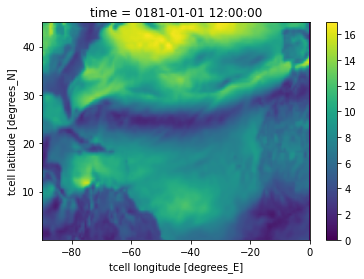

In [8]:
sample = ds_atmos.wind.isel(time=0)
    
    
# # This does never run
# regridder(sample).load().plot()

# # This runs without problems
regridder(sample.load()).plot()

In [9]:
with ProgressBar():
    for var in ['wind', 't_ref', 'q_ref', 'ps']:
        ds[var] = regridder(ds_atmos[var].load())
    # ds = xr.merge([ds, ds_atmos_on_ocean_grid])

[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  0.8s


In [10]:
## hopelessly naive approach

# constant density
rho = 1 # order of magnitude [kg/m3]

# Heat capacity
C_P = 1e3 # order of magnitude [J/kg/C]

# Exchange coefficient
C_Hs = 1e-3

In [11]:
hflux_sens_naive = rho * C_P * C_Hs * ds.wind * (ds.t_ref - ds.surface_temp)
hflux_sens_naive = hflux_sens_naive.resample(time='1MS').mean()
hflux_sens_naive

<xarray.DataArray (time: 4, yt_ocean: 505, xt_ocean: 900)>
dask.array<stack, shape=(4, 505, 900), dtype=float32, chunksize=(1, 505, 900), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 00:00:00 ... 0181-04-01 00:00:00
  * yt_ocean  (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 44.75 44.82 44.89 44.97
  * xt_ocean  (xt_ocean) float64 -89.95 -89.85 -89.75 ... -0.25 -0.15 -0.05

In [12]:
ds_flux

<xarray.Dataset>
Dimensions:                    (time: 240, yu_ocean: 2700, xu_ocean: 3600, yt_ocean: 505, xt_ocean: 900, nv: 2)
Coordinates:
    geolat_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(107, 350), meta=np.ndarray>
    geolon_c                   (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t                   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(107, 350), meta=np.ndarray>
  * nv                         (nv) float64 1.0 2.0
  * time                       (time) object 0181-01-16 12:00:00 ... 0200-12-...
  * xt_ocean                   (xt_ocean) float64 -89.95 -89.85 ... -0.15 -0.05
  * xu_ocean                   (xu_ocean) float64 -279.9 -279.8 ... 79.9 80.0
  * yt_ocean                   (yt_ocean) float64 0.05 0.15 0.25 ... 44.89 44.97
  * yu_ocean                   (yu_ocean) float64 -81.09 -81.05 ... 89.96 90.0
Data variables: (12/27)
    bottom_power_u             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    bottom_power_v             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    calving_melt_heat          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 505, 900), meta=np.ndarray>
    ekman_heat                 (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 900), meta=np.ndarray>
    ekman_we                   (time, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 900), meta=np.ndarray>
    evap                       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 505, 900), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 505, 900), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 505, 900), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_bdy_flux.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

Text(0.5, 1.0, 'difference [%]')

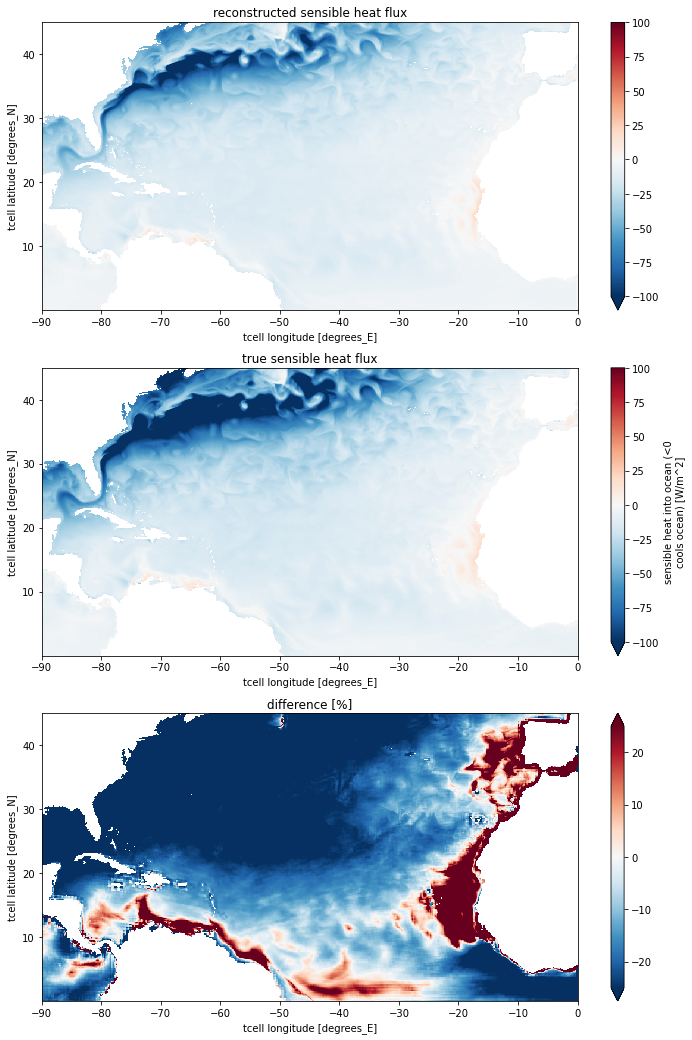

In [13]:
reconstructed = hflux_sens_naive.isel(time=0)
truth = ds_flux.sens_heat.isel(time=0)

import matplotlib.pyplot as plt

plt.figure(figsize=[12,18])

plt.subplot(3,1,1)
reconstructed.plot(vmax=100, center=0)
plt.title('reconstructed sensible heat flux')

plt.subplot(3,1,2)
truth.plot(vmax=100, center=0)
plt.title('true sensible heat flux')

plt.subplot(3,1,3)
((truth-reconstructed)/abs(truth)*100).plot(vmax=25)
plt.title('difference [%]')